In [1]:
import logging
logging.basicConfig(level=0, format="%(asctime)-15s %(name)s %(message)s")

In [2]:
import pandas as pd
from dmagellan.sampler.downsample.downsample import downsample_ddf

In [3]:
from dask import dataframe as dd
from distributed import Client, progress
from dask.diagnostics import ProgressBar, ResourceProfiler, CacheProfiler, Profiler
from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker
from dmagellan.blocker.overlap.overlapblocker import OverlapBlocker

In [4]:
A = dd.read_csv('./movies.csv', blocksize=int(16e6) )
B = dd.read_csv('./songs.csv', blocksize=int(16e6))

In [5]:
A.npartitions

5

In [6]:
# client = Client('127.0.0.1:8786')

In [7]:
from distributed.diagnostics import progress

In [8]:
# A.columns

In [9]:
ab = AttrEquivalenceBlocker()
C = ab.block_tables(A, B, 'id', 'id', 'title', 'title', compute=False)

In [11]:
d = [{'l_id':0, 'r_id':0}]
meta = pd.DataFrame(d)

In [12]:
D = dd.from_delayed(C, meta=meta)

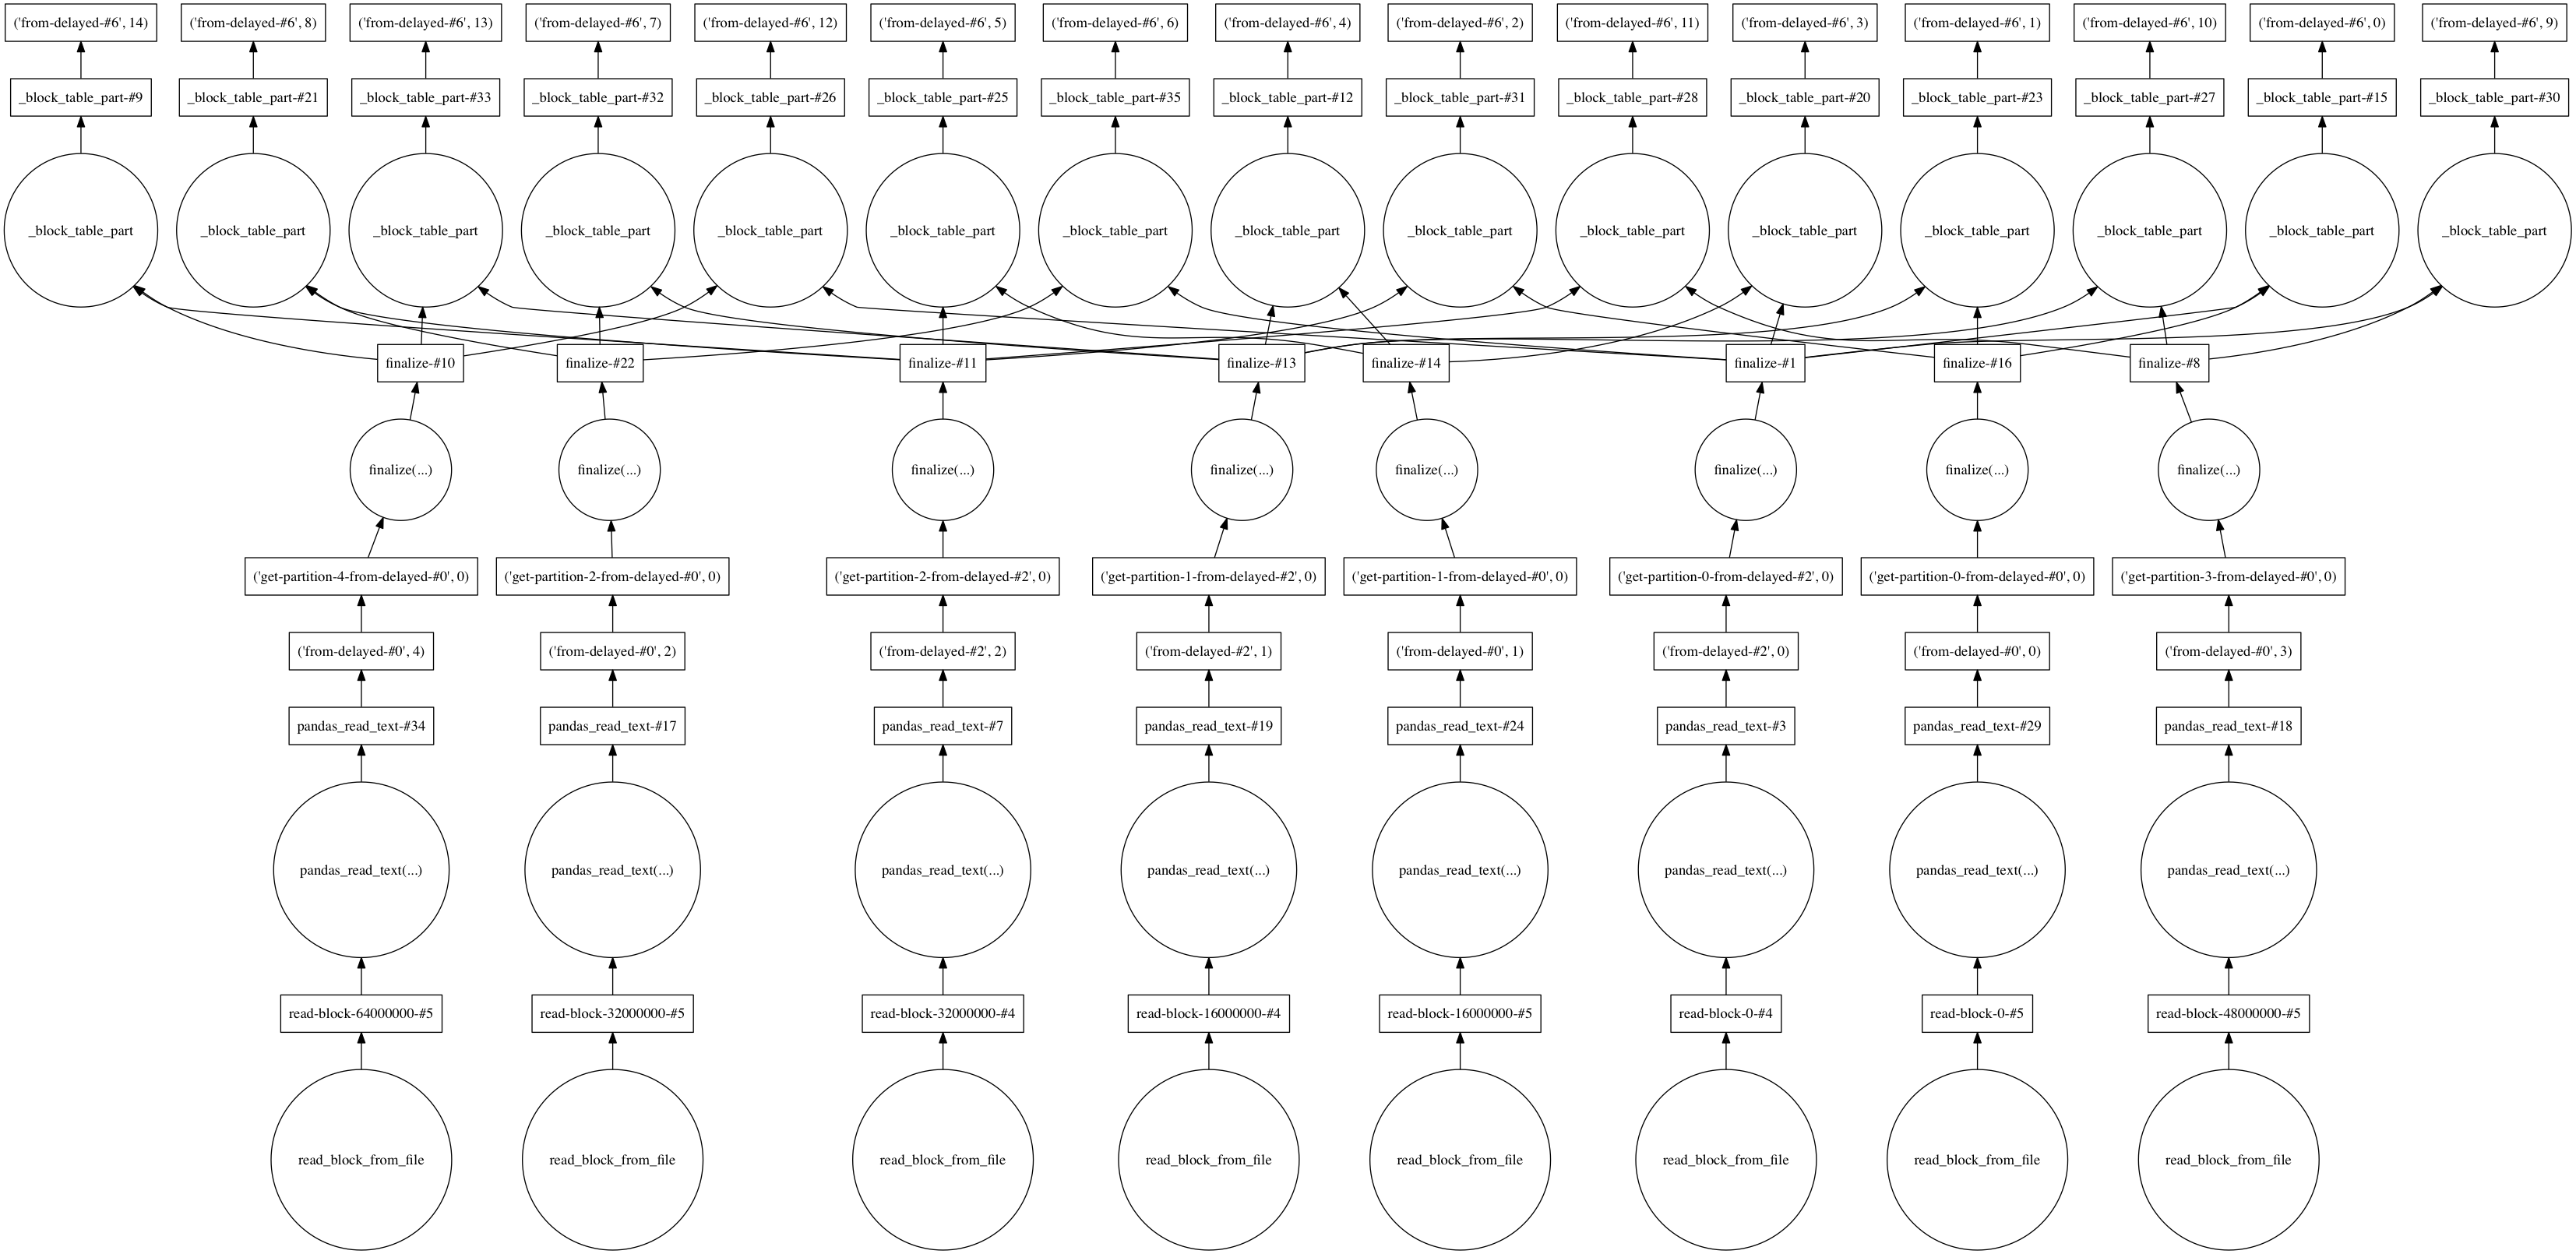

In [13]:
D.visualize()

In [14]:
len(D)

735507

In [16]:
x = []
for i in xrange(D.npartitions):
    x.append(len(D.get_partition(i)))

In [21]:
E = D.persist()

In [22]:
len(E)

735507

In [25]:
p = E.get_partition(0)


In [31]:
x = pd.Series(range(735507))

In [38]:
E.set_index(range(735507), method='disk')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


,l_id,r_id
0,2,37641
1,2,115688
2,2,193899
3,2,278014
4,3,37641


In [36]:
p.assign(_id=pd.Series(range(len(p))))

ValueError: Not all divisions are known, can't align partitions. Please use `set_index` to set the index.

In [96]:
from dask import delayed
from dask.dataframe import from_delayed
def _add_id(df, start, end):
    id_values = list(range(start, end))
    if len(df):
        print(len(id_values))
    #     print(len(df.index.values))
        if '_id' in df.columns:
            df =  df.drop('_id', 1)
        df.insert(0, '_id', id_values)
    return df
    
    
    
def add_id(df):
    x = []
    for i in xrange(df.npartitions):
        x.append(len(df.get_partition(i)))
    results = []
    start = 0
    for i in range(df.npartitions):
        end = x[i]
        r = (delayed)(_add_id)(df.get_partition(i), start, end)
        start = x[i]
        results.append(r)
    d = [{'_id':0, 'l_id':0, 'r_id':0}]
    meta = pd.DataFrame(d)    
    return from_delayed(results, meta=meta)

In [57]:
E.head()

,l_id,r_id
0,2,37641
1,2,115688
2,2,193899
3,2,278014
4,3,37641


In [74]:
G = add_id(E)

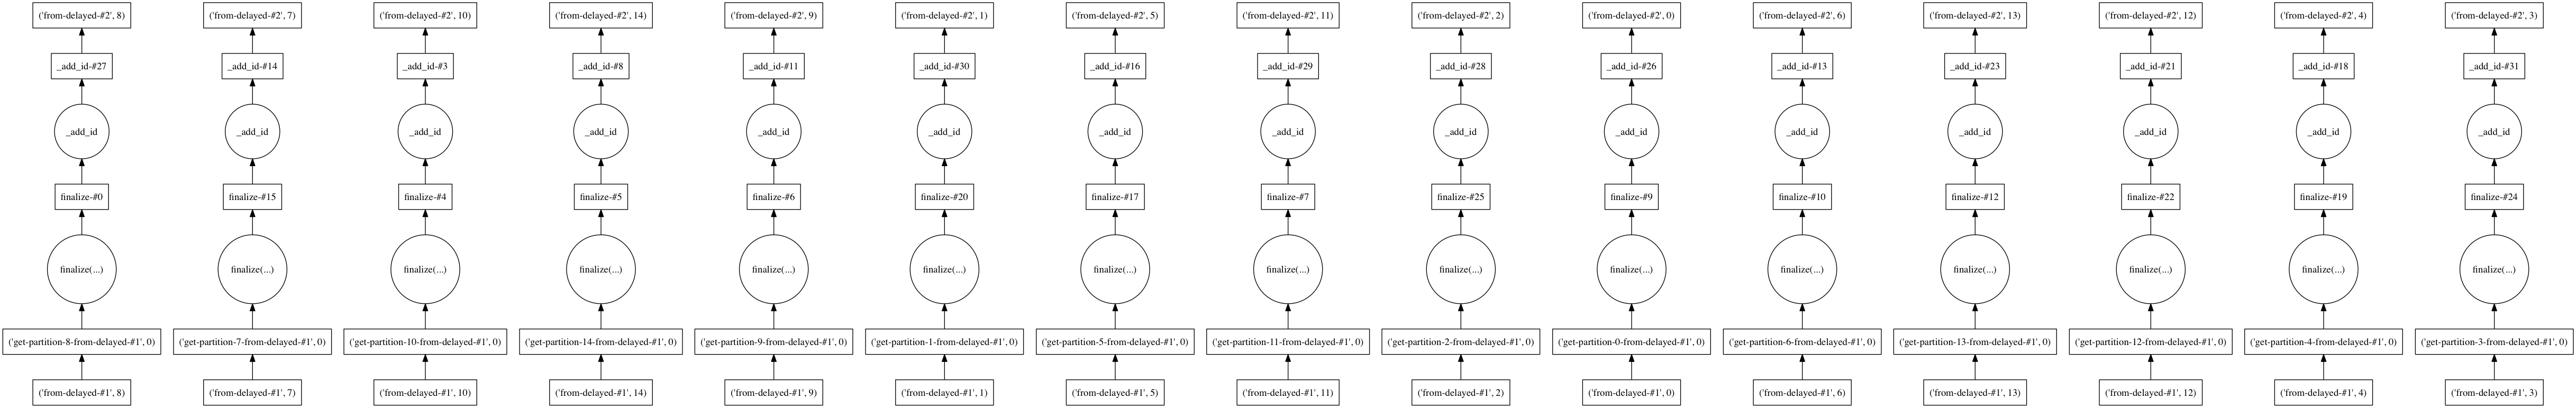

In [71]:
G.visualize()

In [87]:
G = add_id(E)
# H = G.compute()
# progress(H)

In [122]:
def add_id(df):
    x = []
    for i in xrange(df.npartitions):
        x.append(len(df.get_partition(i)))
    b = [0]
    for i in range(len(x)):
        b.append(b[i] + x[i])        
    results = []
#     print(x)
    for i in range(df.npartitions):
        start, end = b[i], b[i+1]
#         print(start, end)
        r = delayed(_add_id)(df.get_partition(i), start, end)
        
        results.append(r)
#     return results
    d = [{'_id':0, 'l_id':0, 'r_id':0}]
    meta = pd.DataFrame(d)    
    return from_delayed(results, meta=meta)

In [115]:
a = [63477, 63367, 42344, 64694, 63853, 43514, 73741, 72602, 48848, 69917, 68198, 46358, 5672, 5398, 3524]
b = [0]
for i in range(len(a)):
    b.append(b[i] + a[i])

In [123]:
G = add_id(E)
H = G.compute()

63477
68198 46358

63367
5672
5398
3524
42344
64694
63853
4351473741

72602
48848
69917


In [125]:
help(E.sample)

Help on method sample in module dask.dataframe.core:

sample(self, frac, replace=False, random_state=None) method of dask.dataframe.core.DataFrame instance
    Random sample of items
    
    Parameters
    ----------
    frac : float, optional
        Fraction of axis items to return.
    replace: boolean, optional
        Sample with or without replacement. Default = False.
    random_state: int or ``np.random.RandomState``
        If int we create a new RandomState with this as the seed
        Otherwise we draw from the passed RandomState
    
    See Also
    --------
        dask.DataFrame.random_split, pd.DataFrame.sample



In [126]:
F = E.sample(frac=0.1)


In [127]:
    x = []
    for i in xrange(F.npartitions):
        x.append(len(F.get_partition(i)))


In [128]:
x

[6348,
 6337,
 4234,
 6469,
 6385,
 4351,
 7374,
 7260,
 4885,
 6992,
 6820,
 4636,
 567,
 540,
 352]

In [124]:
H.tail()

,_id,l_id,r_id
3519,735502,869180,793079
3520,735503,869309,935229
3521,735504,869749,784323
3522,735505,869749,821458
3523,735506,869749,950306


In [47]:
F = E.reset_index(drop=True)

In [52]:
help(d.insert)

Help on built-in function insert:

insert(...)
    L.insert(index, object) -- insert object before index



In [53]:
A1 = A.compute()

In [54]:
A1.insert(0, '_id', len(A), inplace=True)

TypeError: insert() got an unexpected keyword argument 'inplace'